In [13]:
from fast_llm.data.dataset.gpt.memmap import GPTMemmapDataset
from pathlib import Path
import numpy as np
from transformers import AutoTokenizer
import torch
import pickle

import matplotlib.pyplot as plt

In [139]:
files_root = Path("/mnt/datasets/tests/denis/tensors_f32/")
#files_root = Path("/mnt/datasets/tests/denis/tensors/")

In [140]:
fm_files = {int(file.stem.split("tensor")[1]): file for file in (files_root / "fast_llm/logits/").glob("tensor*.pt")}
hf_files = {int(file.stem.split("tensor")[1]): file for file in (files_root / "hf/logits").glob("tensor*.pt")}
assert len(fm_files) == len(hf_files)
len(fm_files)

1000

In [141]:
hf_tokens = []
fm_tokens = []
max_adiff = []
mean_adiff = []
sum_adiff = []
for i in range(len(fm_files)):
    fm_data = torch.load(fm_files[i])
    hf_data = torch.load(hf_files[i])
    
    hf_tokens.append(hf_data[0, -1, :].argmax().item())
    fm_tokens.append(fm_data[0, -1, :].argmax().item())

    adiff = torch.abs(hf_data[0, -1, :] - fm_data[0, -1, :])
    max_adiff.append(adiff.max().item())
    mean_adiff.append(adiff.mean().item())
    sum_adiff.append(adiff.sum().item())
    
all(a == b for a, b in zip(hf_tokens, fm_tokens))

/tmp/ipykernel_14929/1685567046.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fm_data = torch.load(fm_files[i])
/tmp/ipykernel_14929/1685567046.py:8: FutureWarning: Yo

True

In [129]:
min(len(hf_tokens)+1 if ab[0] == ab[1] else i for i, ab in enumerate(zip(hf_tokens, fm_tokens)))

107

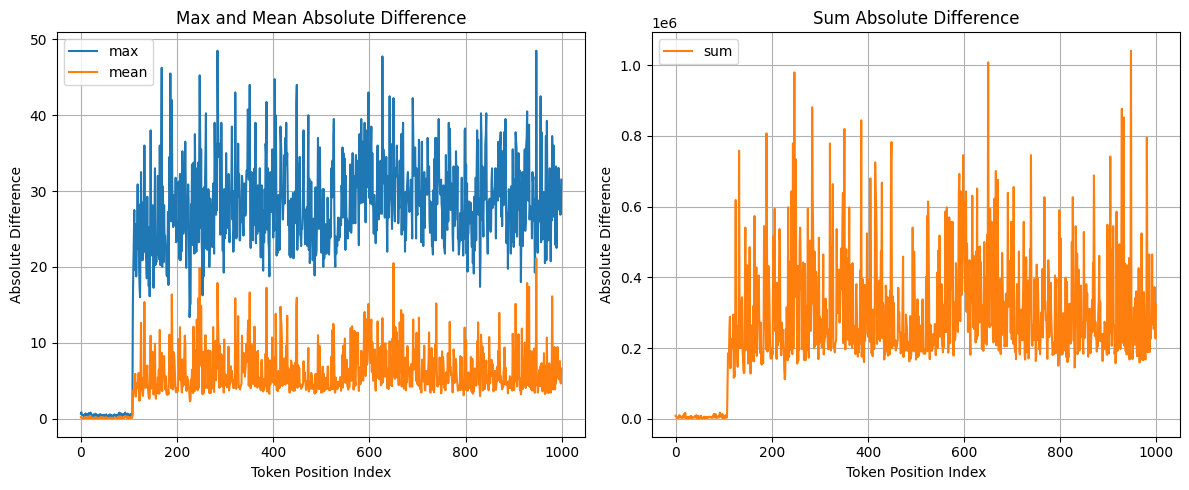

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Left plot: max and mean absolute differences
axes[0].plot(max_adiff, label='max')
axes[0].plot(mean_adiff, label='mean')
axes[0].set_title('Max and Mean Absolute Difference')
axes[0].set_xlabel('Token Position Index')
axes[0].set_ylabel('Absolute Difference')
axes[0].legend()
axes[0].grid(True)

# Right plot: sum absolute difference
axes[1].plot(sum_adiff, label='sum', color='tab:orange')
axes[1].set_title('Sum Absolute Difference')
axes[1].set_xlabel('Token Position Index')
axes[1].set_ylabel('Absolute Difference')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [131]:
fm_hidden_files = {int(file.stem.split("data")[1]): file for file in (files_root / "fast_llm/hidden_states/").glob("data*.pickle")}
hf_hidden_files = {int(file.stem.split("data")[1]): file for file in (files_root / "hf/hidden_states").glob("data*.pickle")}

In [132]:
def mad(new_token_index, fm_hidden_files, hf_hidden_files):
    with fm_hidden_files[new_token_index].open("rb") as f:
        fm_data = pickle.load(f)
    with hf_hidden_files[new_token_index].open("rb") as f:
        hf_data = pickle.load(f)
    max_adiffs_hidden_layers = []
    for i in range(len(hf_data)):
        max_adiff = torch.abs(hf_data[i][0,-1,:]-fm_data[i]['tensor'][0,-1,:]).max().item()
        max_adiffs_hidden_layers.append(max_adiff)
    return max_adiffs_hidden_layers
    

In [133]:
new_token_index = 107
new_token_index1 = 108
max_adiffs_hidden_layers = mad(0, fm_hidden_files, hf_hidden_files)
max_adiffs_hidden_layers2 = mad(new_token_index, fm_hidden_files, hf_hidden_files)
max_adiffs_hidden_layers3 = mad(new_token_index1, fm_hidden_files, hf_hidden_files)

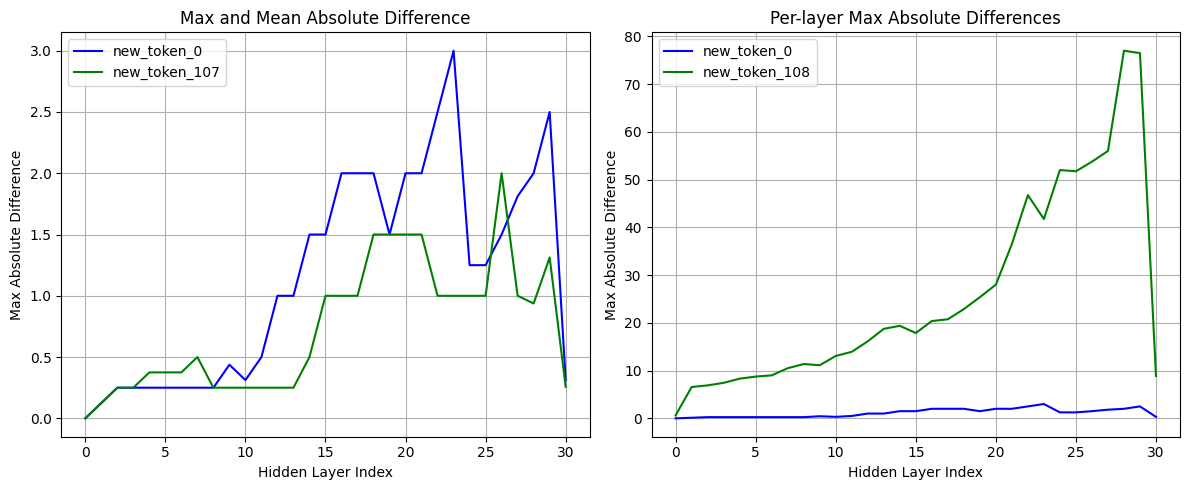

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

axes[0].plot(max_adiffs_hidden_layers, label='new_token_0', color='blue')
axes[0].plot(max_adiffs_hidden_layers2, label=f'new_token_{new_token_index}', color='green')
axes[0].set_title('Max and Mean Absolute Difference')
axes[0].set_xlabel('Hidden Layer Index')
axes[0].set_ylabel('Max Absolute Difference')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(max_adiffs_hidden_layers, label='new_token_0', color='blue')
axes[1].plot(max_adiffs_hidden_layers3, label=f'new_token_{new_token_index1}', color='green')
axes[1].set_title('Max and Mean Absolute Difference')
axes[1].set_xlabel('Hidden Layer Index')
axes[1].set_ylabel('Max Absolute Difference')
axes[1].legend()
axes[1].grid(True)



plt.title('Per-layer Max Absolute Differences')
plt.tight_layout()
plt.show()

In [144]:
print(hf_tokens_bf16[106:120])
print(fm_tokens_b16[106:120])

[2389, 28, 527, 26648, 357, 2258, 260, 3712, 282, 260, 635, 4062, 12903, 30]
[2389, 284, 260, 1439, 357, 3593, 30, 378, 540, 6207, 260, 1569, 28, 260]


In [145]:
print(hf_tokens[106:120])
print(fm_tokens[106:120])

[2389, 284, 260, 1439, 357, 3593, 30, 378, 540, 6207, 260, 1569, 28, 260]
[2389, 284, 260, 1439, 357, 3593, 30, 378, 540, 6207, 260, 1569, 28, 260]


In [136]:
hf_tokens_bf16  = hf_tokens
fm_tokens_b16 = fm_tokens

In [152]:
min(len(hf_tokens)+1 if ab[0] == ab[1] else i for i, ab in enumerate(zip(hf_tokens, fm_tokens)))

1001

In [153]:
min(len(hf_tokens)+1 if ab[0] == ab[1] else i for i, ab in enumerate(zip(hf_tokens, hf_tokens_bf16)))

107

In [154]:
min(len(hf_tokens)+1 if ab[0] == ab[1] else i for i, ab in enumerate(zip(fm_tokens, fm_tokens_b16)))

174

In [151]:
min(len(hf_tokens)+1 if ab[0] == ab[1] else i for i, ab in enumerate(zip(hf_tokens, fm_tokens)))

1001